In [1]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import json


from src.data_tools.czech_data_tools import load_czech_media_data
from src.models.predictor import TrollPredictor

In [2]:
# Configuration
MODEL_NAME = "ufal/robeczech-base"
COMMENTS_PER_USER = 10 # Number of comments to represent a user
MAX_LENGTH = 96      # Max token length per comment
DATA_DIR = Path('data')
OUTPUT_CSV = "user_anomaly_scores.csv"
N_AUTHORS_TO_PROCESS = 10000 # Limit number of authors processed (set to None for all)
MIN_COMMENTS_FOR_REPORTING = 5 # Min comments for an author to be in top/bottom lists
ANNOTATE_TOP_N = 10 # Number of top authors to annotate on plot

# --- Anomaly Detection Parameters ---
IFOREST_CONTAMINATION = 0.1
# LOF parameters (n_neighbors is key, equivalent to contamination is not direct)
LOF_N_NEIGHBORS = 20
LOF_CONTAMINATION = 'auto' # Can be float or 'auto'

In [3]:
# Predictor from Checkpoint
predictor = TrollPredictor(
    model_path= "./checkpoints/best_model.pt",
    comments_per_user=20,
    max_length=96
)

# Initialize Predictor from Hugging Face pretrained Model
# try:
#     predictor = TrollPredictor(
#         model_name=MODEL_NAME,
#         comments_per_user=COMMENTS_PER_USER,
#         max_length=MAX_LENGTH
#     )
# except Exception as e:
#     print(f"Error initializing TrollPredictor: {e}")
#     exit() # Stop if predictor fails
    

In [4]:
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_media_parquet = PROCESSED_DIR / 'czech_media_comments.parquet'

if czech_media_parquet.exists():
    print(f"Loading preprocessed data from {czech_media_parquet}...")
    czech_comments = pd.read_parquet(czech_media_parquet)
else:
    print("Preprocessed data not found. Loading and processing from source...")
    czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
    # Save processed data (we'll keep cell 6 in case you want to save explicitly)
    czech_comments.to_parquet(czech_media_parquet)
    print(f"Preprocessed data saved to {czech_media_parquet}")

print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading preprocessed data from data/processed/czech_media_comments.parquet...
Loaded 845764 comments from 66590 unique authors


In [50]:
# Prepare Account Embeddings
account_embeddings = []
processed_authors = []

# Filter 'N_AUTHORS_TO_PROCESS' with at least `COMMENTS_PER_USER` comments
authors = [
    author for author, count in czech_comments["author"].value_counts().items()
    if count >= predictor.comments_per_user
][:N_AUTHORS_TO_PROCESS]

unique_authors = czech_comments["author"].unique()
if N_AUTHORS_TO_PROCESS is not None:
    unique_authors = unique_authors[:N_AUTHORS_TO_PROCESS]
    print(f"Processing first {N_AUTHORS_TO_PROCESS} unique authors.")

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
try:
    predictor.model.to(device) # Move model to device
except Exception as e:
     print(f"Could not move model to device {device}: {e}")
     # Continue on CPU if needed, predictor might handle internally or error out

for author in authors:
    group = czech_comments[czech_comments["author"] == author]
    comments = group["text"].tolist()

    if len(comments) >= predictor.comments_per_user:
        comments_processed = comments[:predictor.comments_per_user]
    else:
        # Simple repetition padding - consider averaging comment embeddings instead?
        comments_processed = (comments * ((predictor.comments_per_user // len(comments)) + 1))[:predictor.comments_per_user]

    try:
        # Tokenize
        encoded = predictor.tokenizer(comments_processed, padding=True, truncation=True, max_length=predictor.max_length, return_tensors="pt")

        # Move input tensors to the same device as the model
        encoded = {key: tensor.to(device) for key, tensor in encoded.items()}

        with torch.no_grad():
            # Pass the tokenized inputs to the model
            outputs = predictor.model(
                input_ids=encoded["input_ids"],
                attention_mask=encoded["attention_mask"],
                tweets_per_account=predictor.comments_per_user # Ensure model uses this info if needed
            )
            # Assuming 'account_embedding' is the key for the user-level embedding
            account_emb = outputs["account_embedding"].cpu().numpy()

        # Store embedding and author
        account_embeddings.append(account_emb)
        processed_authors.append(author)

    except Exception as e:
        print(f"Error processing author {author}: {e}")
        # Optional: Decide whether to skip the author or handle the error differently
        
if not account_embeddings:
    print("No embeddings were generated. Exiting.")
    exit()


account_embeddings = np.vstack(account_embeddings)

print(f"Generated {account_embeddings.shape[0]} user embeddings with dimension {account_embeddings.shape[1]}.")

Processing first 10000 unique authors.
Using device: cuda
Generated 9845 user embeddings with dimension 768.


In [51]:
# Save account embeddings to a file
embeddings_file = PROCESSED_DIR / 'account_embeddings_my_model.npy'
np.save(embeddings_file, account_embeddings)
print(f"Account embeddings saved to {embeddings_file}")

Account embeddings saved to data/processed/account_embeddings_my_model.npy


In [52]:
account_embeddings = np.load(embeddings_file)

In [53]:
# Filter out slovak authors
with open("./output/slovak_authors.json", "r", encoding="utf-8") as f:
    slovak_authors = set(json.load(f))

# Build mask for non-Slovak authors
filtered_indices = [i for i, author in enumerate(processed_authors) if author not in slovak_authors]

# Filter both lists
filtered_authors = [processed_authors[i] for i in filtered_indices]
account_embeddings = account_embeddings[filtered_indices]

print(f"Filtered from {len(processed_authors)} to {len(filtered_authors)} authors (non-Slovak only).")

Filtered from 9845 to 9786 authors (non-Slovak only).


In [54]:
# Fit Isolation Forest
print(f"\n--- Running Isolation Forest (contamination={IFOREST_CONTAMINATION}) ---")
clf_iforest = IsolationForest(contamination=IFOREST_CONTAMINATION, random_state=42, n_jobs=-1) # Use n_jobs=-1 for parallelization
clf_iforest.fit(account_embeddings)
scores_iforest = -clf_iforest.decision_function(account_embeddings)


--- Running Isolation Forest (contamination=0.1) ---


In [55]:
# Anomaly Detection: Local Outlier Factor (LOF)
print(f"\n--- Running Local Outlier Factor (n_neighbors={LOF_N_NEIGHBORS}) ---")
clf_lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=LOF_CONTAMINATION, novelty=False, n_jobs=-1) # novelty=False for fitting on training data
clf_lof.fit(account_embeddings)
# negative_outlier_factor_: Higher score means higher density (more normal). Lower score means lower density (more abnormal).
# We negate it so that higher scores indicate higher abnormality, similar to the modified IForest score.
scores_lof = -clf_lof.negative_outlier_factor_


--- Running Local Outlier Factor (n_neighbors=20) ---


In [56]:
print(len(processed_authors))

9845


In [58]:
# Prepare Results DataFrame (using Isolation Forest scores for ranking/saving)
print("\n--- Preparing and Saving Results (based on Isolation Forest) ---")
results_df = pd.DataFrame({
    "author": filtered_authors,
    "anomaly_score_iforest": scores_iforest,
    "anomaly_score_lof": scores_lof # Include LOF scores as well
})
results_df = results_df.sort_values("anomaly_score_iforest", ascending=False)

# Filter authors by minimum comment count for reporting
author_comment_counts = czech_comments["author"].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= MIN_COMMENTS_FOR_REPORTING].index
results_df_filtered = results_df[results_df["author"].isin(authors_with_min_comments)]

print(f"\nTop {ANNOTATE_TOP_N} most anomalous authors (iForest score, >= {MIN_COMMENTS_FOR_REPORTING} comments):")
print(results_df_filtered.head(ANNOTATE_TOP_N))

results_df.to_csv(OUTPUT_CSV, index=False)
print(f"Results saved to {OUTPUT_CSV}")

# Print top 10 authors based on LOF scores
results_df_lof_sorted = results_df_filtered.sort_values("anomaly_score_lof", ascending=False)
print(f"\nTop {ANNOTATE_TOP_N} most anomalous authors (LOF score, >= {MIN_COMMENTS_FOR_REPORTING} comments):")
print(results_df_lof_sorted.head(ANNOTATE_TOP_N))

results_df_lof_sorted.to_csv("user_anomaly_scores_lof.csv", index=False)
print(f"Results saved to user_anomaly_scores_lof.csv")




--- Preparing and Saving Results (based on Isolation Forest) ---

Top 10 most anomalous authors (iForest score, >= 5 comments):
                 author  anomaly_score_iforest  anomaly_score_lof
4027   Vladimír Kalinay               0.254494           1.286896
8832        Jan Jiříček               0.249950           1.063876
7157  Radoslav Nešpůrek               0.248959           1.133372
1865        Honza Drdla               0.246790           1.398825
1939    Pavel Rehberger               0.246376           1.126842
8181       Jan Javorský               0.245293           1.103428
5154       Štěpán Malák               0.244948           1.211028
8720       Jindra Macek               0.243535           1.102401
1346      Richard Benes               0.238776           1.084114
6978    Drahomír Krejčí               0.236676           1.012064
Results saved to user_anomaly_scores.csv

Top 10 most anomalous authors (LOF score, >= 5 comments):
                 author  anomaly_score_ifores


--- Generating Visualizations ---


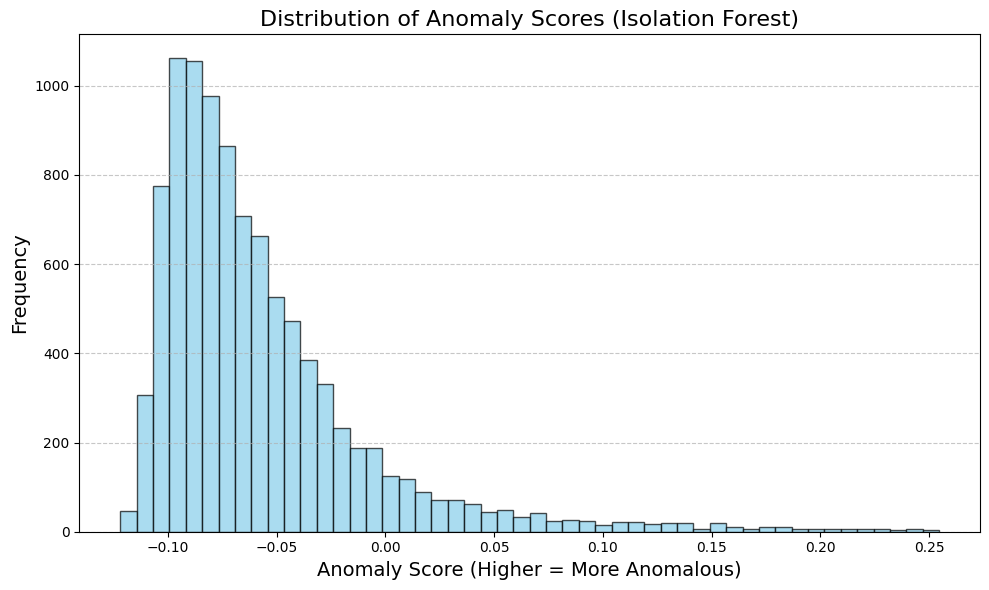

In [59]:
# Visualization 
print("\n--- Generating Visualizations ---")

# 1. Distribution of Anomaly Scores (Isolation Forest)
plt.figure(figsize=(10, 6))
plt.hist(results_df["anomaly_score_iforest"], bins=50, color="skyblue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores (Isolation Forest)", fontsize=16)
plt.xlabel("Anomaly Score (Higher = More Anomalous)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

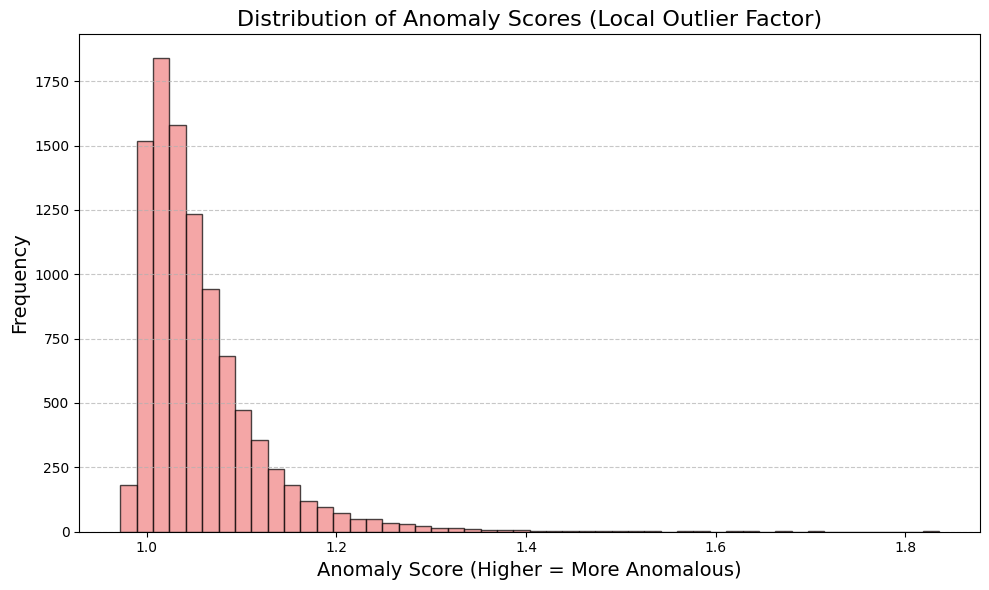

In [60]:
# Plot the distribution of LOF scores
plt.figure(figsize=(10, 6))
plt.hist(scores_lof, bins=50, color="lightcoral", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores (Local Outlier Factor)", fontsize=16)
plt.xlabel("Anomaly Score (Higher = More Anomalous)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Running t-SNE (perplexity=30)...
Plotting annotated t-SNE...


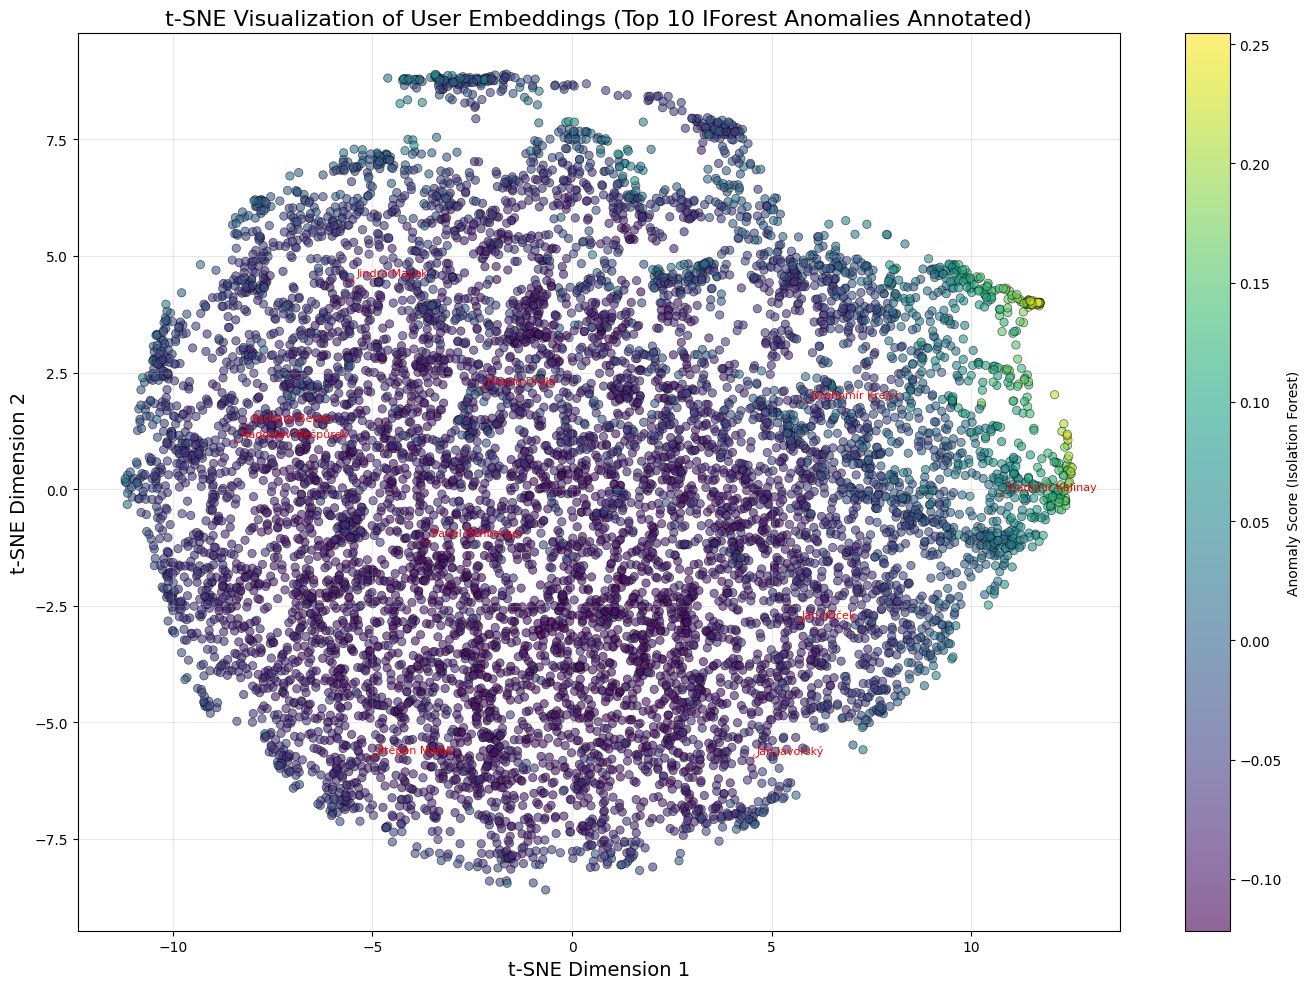

In [61]:
# t-SNE Visualization with Annotations
# Ensure we have enough data points for t-SNE perplexity
perplexity_val = min(30, account_embeddings.shape[0] - 1)
if perplexity_val <= 0:
    print("Not enough samples for t-SNE visualization.")
else:
    print(f"Running t-SNE (perplexity={perplexity_val})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=300, n_jobs=-1) # Reduced iterations, added n_jobs
    tsne_embs = tsne.fit_transform(account_embeddings)

    print("Plotting annotated t-SNE...")
    plt.figure(figsize=(14, 10)) # Larger plot for annotations

    # Determine coloring
    scatter_color_data = scores_iforest
    color_label = "Anomaly Score (Isolation Forest)"
    cmap = "viridis"

    scatter = plt.scatter(
        tsne_embs[:, 0],
        tsne_embs[:, 1],
        c=scatter_color_data,
        cmap=cmap,
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        norm=plt.Normalize(vmin=np.nanmin(scatter_color_data), vmax=np.nanmax(scatter_color_data)) if cmap != "coolwarm" else None # Normalize non-categorical
    )

    plt.colorbar(scatter, label=color_label)
    plt.title(f"t-SNE Visualization of User Embeddings (Top {ANNOTATE_TOP_N} IForest Anomalies Annotated)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(alpha=0.3)

    # Add Annotations for Top N authors (from the filtered results)
    top_authors_to_annotate = results_df_filtered.head(ANNOTATE_TOP_N)

    for _, row in top_authors_to_annotate.iterrows():
        # Find the original index of the author in the 'processed_authors' list
        try:
            original_index = processed_authors.index(row['author'])
            plt.annotate(
                #f"{row['author']} ({row['anomaly_score_iforest']:.2f})", # Annotate with author name + score
                 f"{row['author']}", # Annotate with author name only for less clutter
                (tsne_embs[original_index, 0], tsne_embs[original_index, 1]),
                textcoords="offset points",
                xytext=(5,5),
                ha='left',
                fontsize=8,
                color='red',
                arrowprops=dict(arrowstyle="->", color='red', lw=0.5, connectionstyle="arc3,rad=0.3") # Added connection style
            )
        except ValueError:
             print(f"Warning: Author '{row['author']}' not found in original processed list for annotation.")
        except IndexError:
             print(f"Warning: Index issue for author '{row['author']}' during annotation.")


    plt.tight_layout()
    plt.show()


Running t-SNE (perplexity=30)...
Plotting t-SNE with LOF scores...


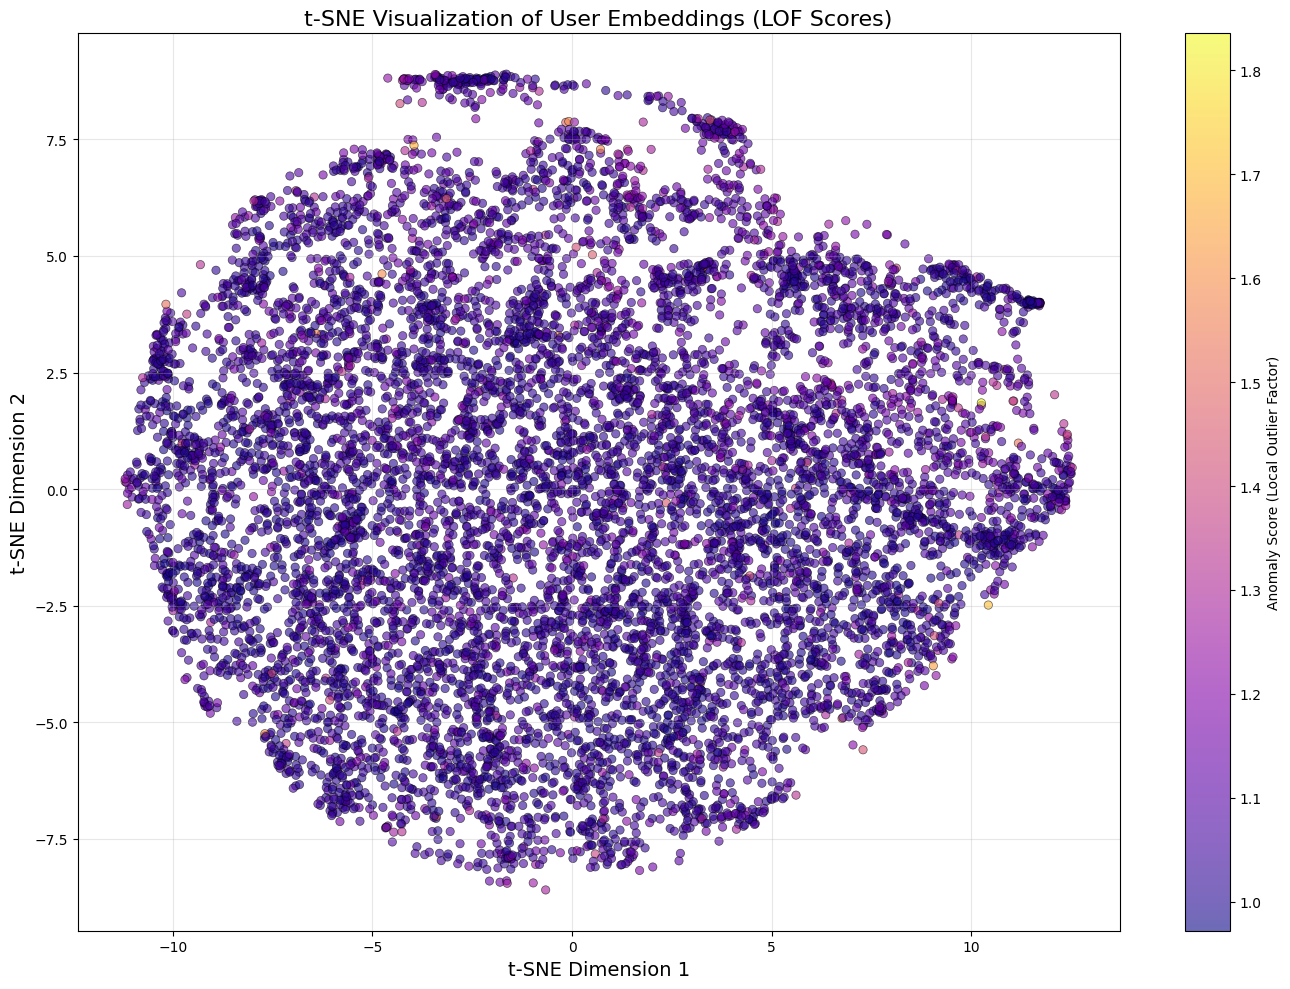

In [62]:
# t-SNE Visualization with LOF Scores
perplexity_val = min(30, account_embeddings.shape[0] - 1)
if perplexity_val <= 0:
    print("Not enough samples for t-SNE visualization.")
else:
    print(f"Running t-SNE (perplexity={perplexity_val})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=300, n_jobs=-1)
    tsne_embs = tsne.fit_transform(account_embeddings)

    print("Plotting t-SNE with LOF scores...")
    plt.figure(figsize=(14, 10))

    scatter = plt.scatter(
        tsne_embs[:, 0],
        tsne_embs[:, 1],
        c=scores_lof,
        cmap="plasma",
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        norm=plt.Normalize(vmin=np.nanmin(scores_lof), vmax=np.nanmax(scores_lof))
    )

    plt.colorbar(scatter, label="Anomaly Score (Local Outlier Factor)")
    plt.title("t-SNE Visualization of User Embeddings (LOF Scores)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [63]:
# Show Sample Comments
# (Kept the logic from the previous script, using the filtered top/bottom from IForest)

print(f"\n--- Sample comments from Top {ANNOTATE_TOP_N} Anomalous Authors (iForest, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
top_authors_list = results_df_filtered.head(ANNOTATE_TOP_N)["author"].tolist()
for author in top_authors_list:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5] # Show first 5
    print(f"\nAuthor: {author} (Score: {results_df[results_df['author'] == author]['anomaly_score_iforest'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)

print(f"\n--- Sample comments from Least {ANNOTATE_TOP_N} Anomalous Authors (iForest, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
bottom_authors_list = results_df_filtered.tail(ANNOTATE_TOP_N)["author"].tolist()
for author in bottom_authors_list:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5] # Show first 5
    print(f"\nAuthor: {author} (Score: {results_df[results_df['author'] == author]['anomaly_score_iforest'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)



--- Sample comments from Top 10 Anomalous Authors (iForest, >= 5 comments) ---

Author: Vladimír Kalinay (Score: 0.25)
 - Comment 1: Co politik to podvodník a lhář ✌️✌️✌️
 - Comment 2: Politika se má dělat prospěch národa , ne pomluvami a zdražováním a lhaním ✌️✌️✌️
 - Comment 3: Naše elita nám ukazuje za kolik dělat ať je nám jedno kolik stojí
 - Comment 4: A z těch oken můžou padat ti posílají lidi do války furt a u nás je jich taky dost ✌️✌️✌️✌️
 - Comment 5: To přece není normální kupovat dráž když to jde levněji z trubek ! Ale to je politika těch našich ELIT !!✌️✌️✌️
----------------------------------------

Author: Jan Jiříček (Score: 0.25)
 - Comment 1: Rozumí tomu někdo?
 - Comment 2: Do pekla Hamásem …
 - Comment 3: Psi a děti dohromady… moje noční můra …
 - Comment 4: Byli, jsou a budou divní …. Slováci …
 - Comment 5: Měli banány a toaletní papír???
----------------------------------------

Author: Radoslav Nešpůrek (Score: 0.25)
 - Comment 1: Německá klasika v přímém přeno

In [64]:
results_df_lof_sorted

# Print top 10 most anomalous comments based on LOF scores
print(f"\n--- Sample comments from Top {ANNOTATE_TOP_N} Anomalous Authors (LOF, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
for author in results_df_lof_sorted.head(ANNOTATE_TOP_N)["author"].tolist():
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5]  # Show first 5 comments
    print(f"\nAuthor: {author} (LOF Score: {results_df[results_df['author'] == author]['anomaly_score_lof'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)

# Print top 10 least anomalous comments based on LOF scores
print(f"\n--- Sample comments from Least {ANNOTATE_TOP_N} Anomalous Authors (LOF, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
bottom_authors_list_lof = results_df_lof_sorted.tail(ANNOTATE_TOP_N)["author"].tolist()
for author in bottom_authors_list_lof:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5]  # Show first 5 comments
    print(f"\nAuthor: {author} (LOF Score: {results_df[results_df['author'] == author]['anomaly_score_lof'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)


--- Sample comments from Top 10 Anomalous Authors (LOF, >= 5 comments) ---

Author: František Osvald (LOF Score: 1.84)
 - Comment 1: Pražský magistrát? To je a byla vždycky partička!
 - Comment 2: Petr VeselýBěž se opláchnout studenou vodou!
 - Comment 3: Vladimír KociánTak!
 - Comment 4: Tvrdě trestat v milionech!
 - Comment 5: Oldřich StračekDoufejme!
----------------------------------------

Author: Michael Budera (LOF Score: 1.71)
 - Comment 1: -----------------------------------------------------------------------------Souhlasím. Hlavně to může být katastrofa pro Koláře a tu jeho štváčskou partičku...
 - Comment 2: To je vážně tragikomedie... Ti, kteří takový let objednají, by ho měli zaplatit ze svého!
 - Comment 3: „Důvod nárůstu je poměrně jednoduchý, ruské LNG je proti ostatním dodavatelům nabízeno se slevou. Bez sankcí uvalených na komoditu firmy jednají vlastním zájmu a kupují stále větší množství plynu od nejlevnějšího dodavatele,“ řekl analytik společnosti Crea Vaibhav Ra

In [65]:
print("\n--- Running Predictor Inference for Each Author ---")

predictor_results = []

for author in filtered_authors:
    comments = czech_comments[czech_comments["author"] == author]["text"].tolist()

    if len(comments) < predictor.comments_per_user:
        comments = (comments * ((predictor.comments_per_user // len(comments)) + 1))[:predictor.comments_per_user]
    else:
        comments = comments[:predictor.comments_per_user]

    try:
        prediction = predictor.predict_batch(comments)
        predictor_results.append({
            "author": author,
            "troll_prediction": prediction["prediction"],
            "troll_confidence": prediction["confidence"],
            "troll_prob": prediction["probabilities"][1]
        })
    except Exception as e:
        print(f"Prediction failed for {author}: {e}")

predictor_df = pd.DataFrame(predictor_results)
print(f"Predictions completed for {len(predictor_df)} authors.")


--- Running Predictor Inference for Each Author ---
Predictions completed for 9786 authors.


In [66]:
results_df = results_df.merge(predictor_df, on="author", how="left")

# Update filtered version
results_df_filtered = results_df[results_df["author"].isin(authors_with_min_comments)]

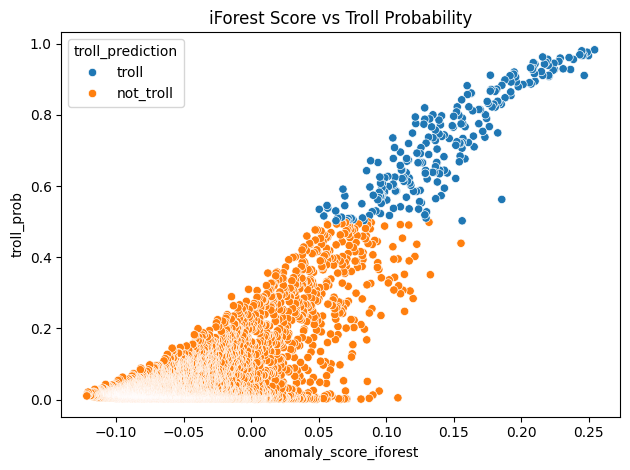

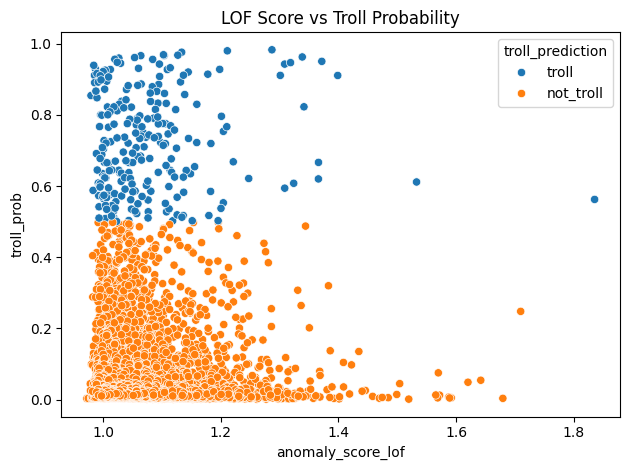

Correlation (iForest ↔ troll prob): 0.810195201769016
Correlation (LOF ↔ troll prob): 0.08886216803492816


In [67]:
import seaborn as sns

# Plot: iForest score vs troll probability
sns.scatterplot(data=results_df, x="anomaly_score_iforest", y="troll_prob", hue="troll_prediction")
plt.title("iForest Score vs Troll Probability")
plt.tight_layout()
plt.show()

# Plot: LOF score vs troll probability
sns.scatterplot(data=results_df, x="anomaly_score_lof", y="troll_prob", hue="troll_prediction")
plt.title("LOF Score vs Troll Probability")
plt.tight_layout()
plt.show()

# Print correlation values
print("Correlation (iForest ↔ troll prob):", results_df["anomaly_score_iforest"].corr(results_df["troll_prob"]))
print("Correlation (LOF ↔ troll prob):", results_df["anomaly_score_lof"].corr(results_df["troll_prob"]))


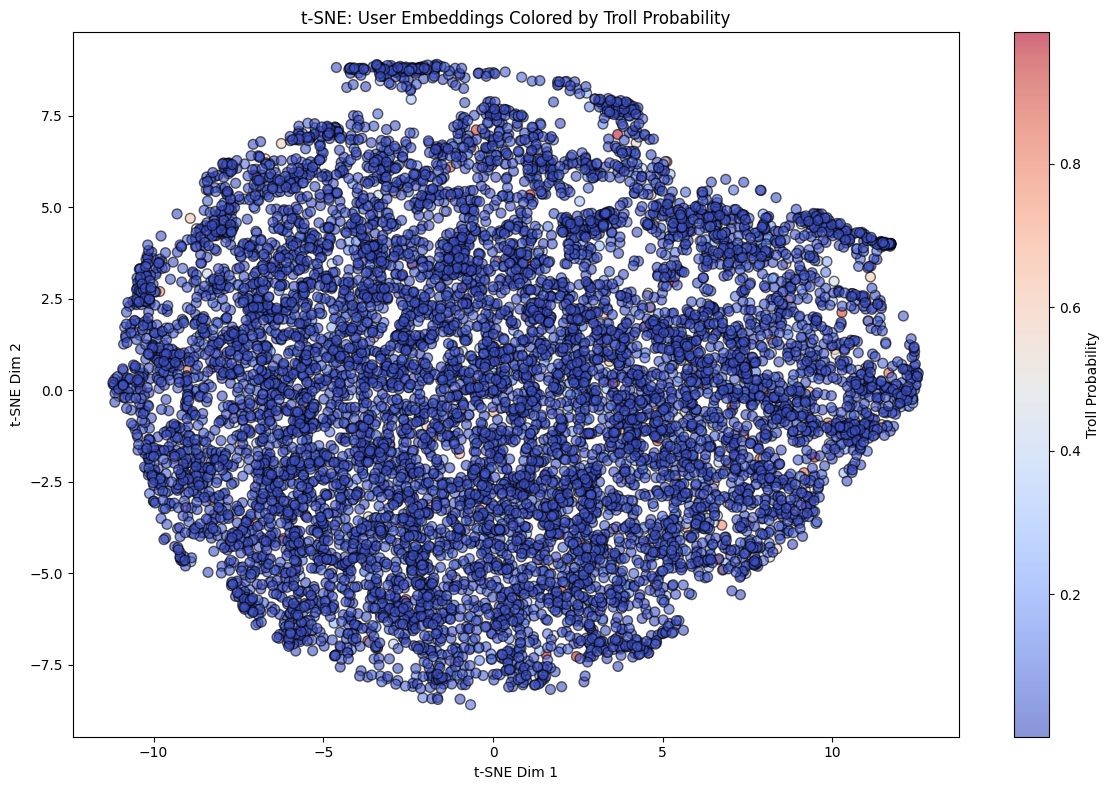

In [68]:
# Use same tsne_embs from before
if 'tsne_embs' not in locals():
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_embs = tsne.fit_transform(account_embeddings)

# Color by troll probability
plt.figure(figsize=(12, 8))
plt.scatter(
    tsne_embs[:, 0],
    tsne_embs[:, 1],
    c=results_df["troll_prob"],
    cmap="coolwarm",
    s=50,
    alpha=0.6,
    edgecolor='k'
)
plt.colorbar(label="Troll Probability")
plt.title("t-SNE: User Embeddings Colored by Troll Probability")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

In [ ]:
# Top-K most confident trolls
top_trolls = results_df.sort_values("troll_prob", ascending=False).head(10)
print("🔴 Top 10 Most Confident Trolls:")
print(top_trolls[["author", "troll_prob", "anomaly_score_iforest", "anomaly_score_lof"]])

# Top non-trolls
top_non_trolls = results_df.sort_values("troll_prob", ascending=True).head(10)
print("\n🟢 Top 10 Most Confident Non-Trolls:")
print(top_non_trolls[["author", "troll_prob", "anomaly_score_iforest", "anomaly_score_lof"]])

# Trolls with LOW anomaly scores, missed by unsupervised model
missed_trolls = results_df[
    (results_df["troll_prob"] > 0.9) &
    (results_df["anomaly_score_iforest"] < results_df["anomaly_score_iforest"].median())
]
print(f"\n🟡 High-Confidence Trolls Missed by Anomaly Detection: {len(missed_trolls)}")
print(missed_trolls[["author", "troll_prob", "anomaly_score_iforest"]].head(5))

🔴 Top 10 Most Confident Trolls:
               author  troll_prob  anomaly_score_iforest  anomaly_score_lof
0    Vladimír Kalinay    0.983036               0.254494           1.286896
6        Štěpán Malák    0.980188               0.244948           1.211028
2   Radoslav Nešpůrek    0.976249               0.248959           1.133372
7        Jindra Macek    0.969139               0.243535           1.102401
4     Pavel Rehberger    0.967965               0.246376           1.126842
5        Jan Javorský    0.966878               0.245293           1.103428
1         Jan Jiříček    0.966530               0.249950           1.063876
24     Martin Kolařik    0.962890               0.216004           1.338498
10     Josef Fortelný    0.961272               0.235586           1.053331
12       Martin Ondík    0.959815               0.229015           1.026530

🟢 Top 10 Most Confident Non-Trolls:
                   author  troll_prob  anomaly_score_iforest  \
436         Lída Karafiát    0.

In [48]:
print("\n--- 🔍 Sample Comments from Top 10 Most Confident Trolls ---")
for author in top_trolls["author"].tolist():
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:12]
    print(f"\nAuthor: {author} (Troll Probability: {results_df[results_df['author'] == author]['troll_prob'].values[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 60)


--- 🔍 Sample Comments from Top 10 Most Confident Trolls ---

Author: Štěpán Malák (Troll Probability: 0.99)
 - Comment 1: Už se nechce ztrapňovat a ukazovat svoji neschopnost, tak raději hlásí dopředu, že končí. Stejně by se tam už nedostala…
 - Comment 2: Jj, papír snese všechno…
 - Comment 3: Chybička se vloudila, to je jak u našeho premiéra, taky lže kudy chodí…
 - Comment 4: A na to Lipavský, bude reagovat…
 - Comment 5: A na to Lipavský, bude reagovat…
 - Comment 6: Milada KarbanováTak zkuste dojednat mír vy, určitě víte jak na to…
 - Comment 7: Tak pokládej peníze na stůl, ale svoje…
 - Comment 8: Je to v pořádku a chtělo by to ještě ten náskok zvýšit a zbavit se konečně těch lemplů z vlády i nejhorším premiérem tu byl…
 - Comment 9: Fiala je obyčejný lhář a šašek, který ví absolutně kulový a ještě ze sebe dělá troubu…
 - Comment 10: Pavel neví která bije…
 - Comment 11: Nejdříve všechno ruší a pak to chtějí zase obnovit. Všechno bylo špatně a najednou se k tomu vracíme, protože

In [ ]:
def print_sample_comments(df_subset, label="Group", n_comments=5):
    print(f"\n--- 🔍 Sample Comments from {label} ---")
    for author in df_subset["author"].tolist():
        author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:n_comments]
        print(f"\nAuthor: {author} (Troll Probability: {results_df[results_df['author'] == author]['troll_prob'].values[0]:.2f})")
        for i, comment in enumerate(author_comments):
            print(f" - Comment {i+1}: {comment}")
        print("-" * 60)

print_sample_comments(top_trolls, label="Top Trolls")
print_sample_comments(top_non_trolls, label="Top Non-Trolls")


--- 🔍 Sample Comments from Top Trolls ---

Author: Štěpán Malák (Troll Probability: 0.99)
 - Comment 1: Už se nechce ztrapňovat a ukazovat svoji neschopnost, tak raději hlásí dopředu, že končí. Stejně by se tam už nedostala…
 - Comment 2: Jj, papír snese všechno…
 - Comment 3: Chybička se vloudila, to je jak u našeho premiéra, taky lže kudy chodí…
 - Comment 4: A na to Lipavský, bude reagovat…
 - Comment 5: A na to Lipavský, bude reagovat…
------------------------------------------------------------

Author: Josef Fortelný (Troll Probability: 0.99)
 - Comment 1: Jo Zelenský je somrák nevděčný, nic víc…
 - Comment 2: A u nás za to chtějí Okamuru stíhat. Jen upozorňuje na to se děje v Německu atd…
 - Comment 3: No konečně…
 - Comment 4: Tenhle komouš převlékl kabát ať radši drží tu svojí tlamu…
 - Comment 5: Ale copak, že by nějaký chirurg z dovozu.?
------------------------------------------------------------

Author: Zdeněk Pokorný (Troll Probability: 0.99)
 - Comment 1: opět trapná p

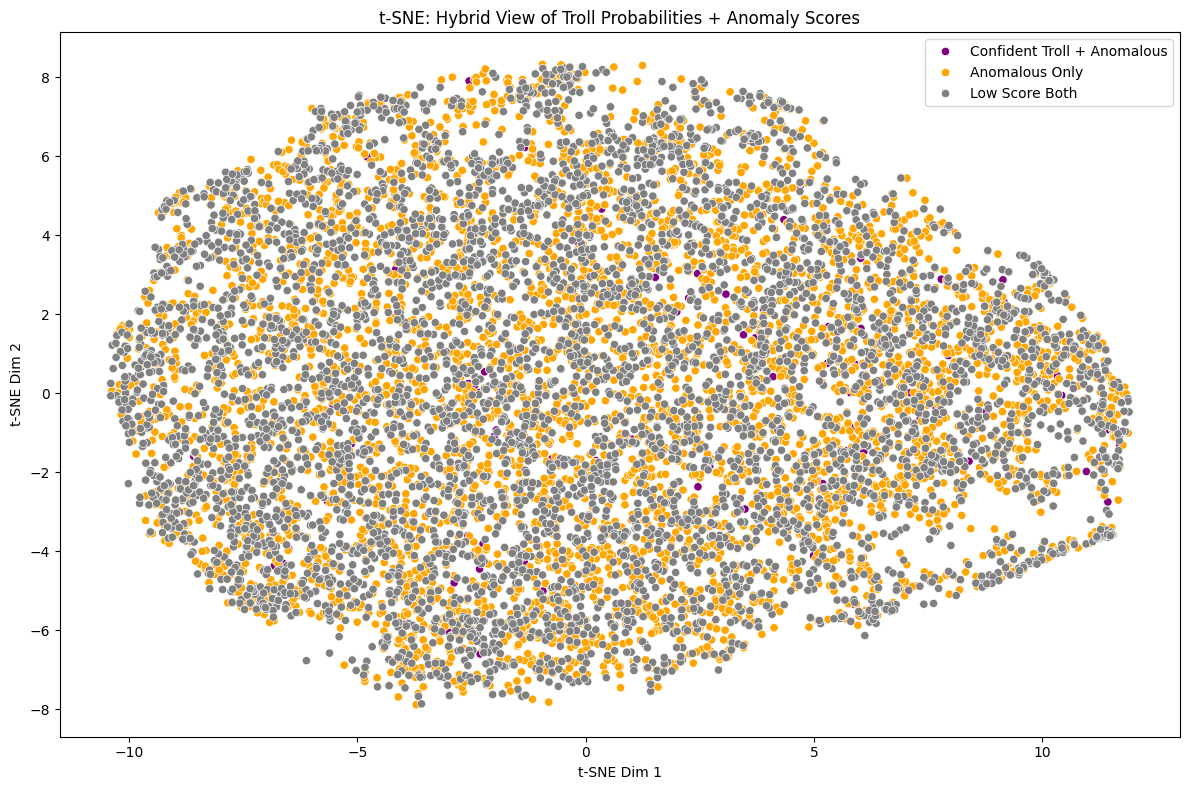

In [44]:
def hybrid_category(row):
    if row["troll_prob"] > 0.9 and row["anomaly_score_iforest"] > results_df["anomaly_score_iforest"].median():
        return "Confident Troll + Anomalous"
    elif row["troll_prob"] > 0.9:
        return "Confident Troll"
    elif row["anomaly_score_iforest"] > results_df["anomaly_score_iforest"].median():
        return "Anomalous Only"
    else:
        return "Low Score Both"

results_df["hybrid_category"] = results_df.apply(hybrid_category, axis=1)

# Plot again
plt.figure(figsize=(12, 8))
palette = {"Confident Troll": "red", "Anomalous Only": "orange", "Confident Troll + Anomalous": "purple", "Low Score Both": "grey"}
sns.scatterplot(x=tsne_embs[:, 0], y=tsne_embs[:, 1], hue=results_df["hybrid_category"], palette=palette)
plt.title("t-SNE: Hybrid View of Troll Probabilities + Anomaly Scores")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.tight_layout()
plt.show()